In [1]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [17]:
def get_bitcoin_data(days=365): 
    cg = CoinGeckoAPI()
    
    # Get price data
    price_data = cg.get_coin_market_chart_by_id(
        id='vechain', 
        vs_currency='usd', 
        days=days
    )
    
    df = pd.DataFrame(price_data['prices'], columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    df = df.drop('timestamp', axis=1)
    
    # Add volume data if available
    if 'total_volumes' in price_data:
        volumes = pd.DataFrame(price_data['total_volumes'], columns=['timestamp', 'volume'])
        volumes['date'] = pd.to_datetime(volumes['timestamp'], unit='ms')
        volumes.set_index('date', inplace=True)
        df['volume'] = volumes['volume']

    df = create_regression_features(df)
    
    return df

In [8]:
def create_regression_features(df):
    df['daily_return'] = df['price'].pct_change() * 100
    
    df['ma_7'] = df['price'].rolling(window=7).mean()  
    df['ma_30'] = df['price'].rolling(window=30).mean()  
    
    df['volatility_7'] = df['daily_return'].rolling(window=7).std()
    df['volatility_30'] = df['daily_return'].rolling(window=30).std()
    
    df['momentum_7'] = df['price'] - df['price'].shift(7)
    df['momentum_30'] = df['price'] - df['price'].shift(30)
    
    if 'high' not in df.columns:
        df['high'] = df['price']
        df['low'] = df['price']
    df['hl_pct'] = (df['high'] - df['low']) / df['low'] * 100
    
    df['pct_change_1d'] = df['price'].pct_change(periods=1) * 100
    df['pct_change_7d'] = df['price'].pct_change(periods=7) * 100
    
    for lag in [1, 2, 3, 5, 7]: 
        df[f'lag_{lag}'] = df['price'].shift(lag)

    df['target'] = df['price'].shift(-1)
    
    df = df.dropna()
    
    return df

In [9]:
def save_to_csv(df, filename='bitcoin_regression_data.csv'):
    df.to_csv(filename)
    print(f"Data successfully saved to {filename}")

def plot_price_history(df):
    plt.figure(figsize=(14, 7))
    df['price'].plot(title='Bitcoin Price History', color='blue')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.grid()
    plt.show()


Data Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 2024-07-31 to 2025-06-30
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          335 non-null    float64
 1   volume         335 non-null    float64
 2   daily_return   335 non-null    float64
 3   ma_7           335 non-null    float64
 4   ma_30          335 non-null    float64
 5   volatility_7   335 non-null    float64
 6   volatility_30  335 non-null    float64
 7   momentum_7     335 non-null    float64
 8   momentum_30    335 non-null    float64
 9   high           335 non-null    float64
 10  low            335 non-null    float64
 11  hl_pct         335 non-null    float64
 12  pct_change_1d  335 non-null    float64
 13  pct_change_7d  335 non-null    float64
 14  lag_1          335 non-null    float64
 15  lag_2          335 non-null    float64
 16  lag_3          335 non-null    float64
 17  lag_5          335 

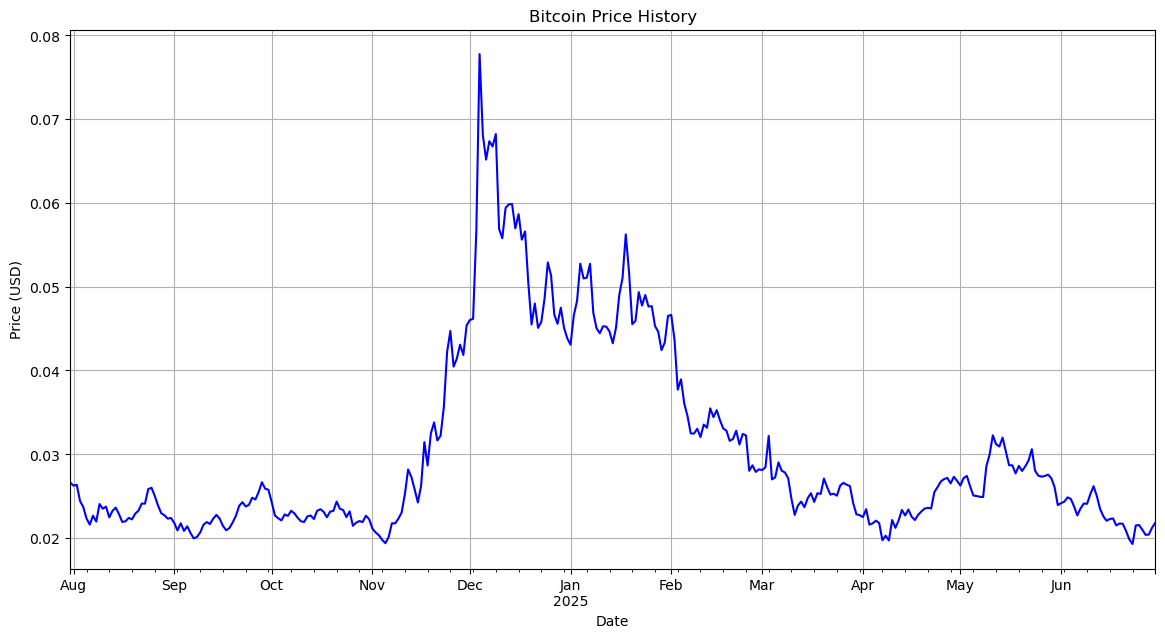


Data preparation complete. The CSV file contains the following columns:
1. price
2. volume
3. daily_return
4. ma_7
5. ma_30
6. volatility_7
7. volatility_30
8. momentum_7
9. momentum_30
10. high
11. low
12. hl_pct
13. pct_change_1d
14. pct_change_7d
15. lag_1
16. lag_2
17. lag_3
18. lag_5
19. lag_7
20. target


In [18]:
if __name__ == "__main__":
    print("Downloading Bitcoin historical data...")
    bitcoin_data = get_bitcoin_data(days=365)  
    
    print("\nData Overview:")
    print(bitcoin_data.info())
    
    print("\nFirst 5 rows:")
    print(bitcoin_data.head())
    
    print("\nLast 5 rows:")
    print(bitcoin_data.tail())
    
    print("\nDescriptive Statistics:")
    print(bitcoin_data.describe())
    
    save_to_csv(bitcoin_data, 'vechain_data.csv')
    
    plot_price_history(bitcoin_data)
    
    print("\nData preparation complete. The CSV file contains the following columns:")
    for i, col in enumerate(bitcoin_data.columns, 1):
        print(f"{i}. {col}")